**Общий анализ крови**

**Концепция работы**

**Цель:** разработать прототип веб-сервиса для виртуального скрининга результатов биохимического анализа крови человека.

**Задачи**:

1. Выполнить разведывательный анализ набора данных по результатам биохимического анализа крови
   
2. Построить релевантные модели машинного обучения для предсказания состояния здоровья пациента по совокупности химических показателей крови
   
3. Создать программу, основанную на результатх предсказания нескольких моделей машинного обучения, для обработки результатов лабораторного анализа крови.

Подобный продукт позволит пациенту получить экспрессный предварительный ответ по полученныи количественных параметрам жидкой соединительной ткани крови и позволит уточнить, необохдимо ли обратиться ко врачу за дополнительной консультацией по текущему состоянию здоровья.

**Этап 1. Подготовка данных**

In [62]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import Ridge

In [2]:
# Загрузка датасета
df = pd.read_csv('undefind_для_студентов.csv', sep = ';')
df

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента
0,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.80,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,1962-09-22 00:00:00
1,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.18,10*12/л,"3,8:5,7",Норм,NaN,NaN,NaN,Ж,1962-09-22 00:00:00
2,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Гемоглобин (HGB),120.00,г/л,117:160,Норм,NaN,NaN,NaN,Ж,1962-09-22 00:00:00
3,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Гематокрит (HCT),35.10,%,35:47,Норм,NaN,NaN,NaN,Ж,1962-09-22 00:00:00
4,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Средний объем эритроцита (MCV),84.00,фл,80:99,Норм,NaN,NaN,NaN,Ж,1962-09-22 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36292,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Базофилы,1.00,%,0:2,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,2014-10-17 00:00:00
36293,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эозинофилы,0.00,%,0:5,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,2014-10-17 00:00:00
36294,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Пролимфоциты,0.00,%,0:0,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,2014-10-17 00:00:00
36295,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лимфоциты,65.00,%,18:44,Повыш,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,2014-10-17 00:00:00


In [4]:
# Создание стобца "Возраст" на основе столбца "Дата рождения пациента"
df['Дата рождения пациента'] = df['Дата рождения пациента'].apply(lambda x: x.split('-'))
df['Возраст'] = df['Дата рождения пациента'].apply(lambda x: 2024-int(x[0]))
df

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
0,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.80,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
1,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.18,10*12/л,"3,8:5,7",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
2,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Гемоглобин (HGB),120.00,г/л,117:160,Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
3,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Гематокрит (HCT),35.10,%,35:47,Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
4,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Средний объем эритроцита (MCV),84.00,фл,80:99,Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36292,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Базофилы,1.00,%,0:2,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,"[2014, 10, 17 00:00:00]",10
36293,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эозинофилы,0.00,%,0:5,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,"[2014, 10, 17 00:00:00]",10
36294,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Пролимфоциты,0.00,%,0:0,Норм,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,"[2014, 10, 17 00:00:00]",10
36295,516f652e-8bb8-11eb-bb95-2cea7fe73f75,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лимфоциты,65.00,%,18:44,Повыш,Комментарий,Тромбоциты проверены. Рекомендована консультац...,_,М,"[2014, 10, 17 00:00:00]",10


In [5]:
# Вывод информации о переменных набора данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36297 entries, 0 to 36296
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID истории болезни                    36297 non-null  object 
 1   Осн. диаг. при выписке МКБ10 (текст)  36297 non-null  object 
 2   Заголовок документа                   36297 non-null  object 
 3   Кол. лаб. показатель                  36236 non-null  object 
 4   Значение кол. показателя              36236 non-null  float64
 5   Ед. изм. кол. показателя              36236 non-null  object 
 6   Норма кол. показателя                 36236 non-null  object 
 7   Флаг нормы кол. показателя            36236 non-null  object 
 8   Кач. лаб. показатель                  7005 non-null   object 
 9   Значение кач. показателя              7005 non-null   object 
 10  Норма кач. показателя                 7005 non-null   object 
 11  Пол            

**Как известно, к наиболее тестируемым биохимическим показателям крови относятся концентрация эритроцитов, лейкоцитов, тромбоцитов, гемоглобина. Отклонение данных параметров от нормы может свидетельствовать о воспалительном процессе, ослабленном иммунном ответе, анемии, недостатке факторов свертывания крови. Поэтому в этой работы будут получены модели МО по предсказанию состояния здоровья пациента по этим (эритроциты, тромбоциты, лейкоциты) биохимических показателям.**

**Этап 2. Создание моделей МО (мультиклассовая логистическая регрессия)**

**2.1. Эритроциты (красные кровяные тельца, RBC)**

In [6]:
# Маска для филтрации данных по эритроцитам
mask_e = (df['Кол. лаб. показатель'] == 'Эритроциты') | (df['Кол. лаб. показатель'] == 'Эритроциты (RBC)') | (df['Кол. лаб. показатель'] == 'RBC')

In [7]:
# Отбор наблюдений с информацией по эритроцитам пациентов
er = df[mask_e]
er

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
1,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.18,10*12/л,"3,8:5,7",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
17,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.64,10*12/л,"3,8:5,7",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
47,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.00,10*12/л,"3,8:5,7",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
77,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.37,10*12/л,"3,8:5,7",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
105,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.92,10*12/л,"3,8:5,7",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36169,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.15,10*12/л,"4,3:6,1",Пониж,Комментарий,"лимфоидные элементы средних размеров,с ядрами ...",_,М,"[1982, 02, 11 00:00:00]",42
36196,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.56,10*12/л,"4,3:6,1",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36218,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.24,10*12/л,"4,3:6,1",Пониж,Комментарий,Лимфоидные элементы с неправильной формой ядра...,_,М,"[1982, 02, 11 00:00:00]",42
36245,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.87,10*12/л,"4,3:6,1",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42


In [8]:
# Создадаим два столбца по верхней и нижней границам нормы содержания эритроцитов
er['Норма кол. показателя'] = er['Норма кол. показателя'].apply(lambda x: x.split(':'))
er['Нижняя граница'] = er['Норма кол. показателя'].apply(lambda x: x[0])
er['Нижняя граница'] = er['Нижняя граница'].apply(lambda x: float(x.replace(',', '.')))
er['Верхняя граница'] = er['Норма кол. показателя'].apply(lambda x: x[1])
er['Верхняя граница'] = er['Верхняя граница'].apply(lambda x: float(x.replace(',', '.')))
er

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\709828780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er['Норма кол. показателя'] = er['Норма кол. показателя'].apply(lambda x: x.split(':'))
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\709828780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  er['Нижняя граница'] = er['Норма кол. показателя'].apply(lambda x: x[0])
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\709828780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст,Нижняя граница,Верхняя граница
1,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.18,10*12/л,"[3,8, 5,7]",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,3.8,5.7
17,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.64,10*12/л,"[3,8, 5,7]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,3.8,5.7
47,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),4.00,10*12/л,"[3,8, 5,7]",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,3.8,5.7
77,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.37,10*12/л,"[3,8, 5,7]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,3.8,5.7
105,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Эритроциты (RBC),3.92,10*12/л,"[3,8, 5,7]",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,3.8,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36169,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.15,10*12/л,"[4,3, 6,1]",Пониж,Комментарий,"лимфоидные элементы средних размеров,с ядрами ...",_,М,"[1982, 02, 11 00:00:00]",42,4.3,6.1
36196,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.56,10*12/л,"[4,3, 6,1]",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42,4.3,6.1
36218,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.24,10*12/л,"[4,3, 6,1]",Пониж,Комментарий,Лимфоидные элементы с неправильной формой ядра...,_,М,"[1982, 02, 11 00:00:00]",42,4.3,6.1
36245,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.87,10*12/л,"[4,3, 6,1]",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42,4.3,6.1


**В качестве независимых переменных модели МО используем текущее содержание эритроцитов в крови и пол пациента**

In [9]:
# Отберем столбцы с независимыми переменными модели
er_ml = er.loc[:,['Значение кол. показателя', 'Пол', 'Возраст']]
er_ml

,Значение кол. показателя,Пол,Возраст
1,4.18,Ж,62
17,3.64,Ж,62
47,4.00,Ж,62
77,3.37,Ж,62
105,3.92,Ж,62
...,...,...,...
36169,1.15,М,42
36196,1.56,М,42
36218,1.24,М,42
36245,1.87,М,42


In [10]:
# Преобразуем столбец (пол) в числовой вид
X = pd.get_dummies(er_ml, dtype=int)
X

,Значение кол. показателя,Возраст,Пол_Ж,Пол_М
1,4.18,62,1,0
17,3.64,62,1,0
47,4.00,62,1,0
77,3.37,62,1,0
105,3.92,62,1,0
...,...,...,...,...
36169,1.15,42,0,1
36196,1.56,42,0,1
36218,1.24,42,0,1
36245,1.87,42,0,1


**В качестве зависимой переменной (таргета) модели принимаем состояние здоровья (потенциальный диагноз пациента)**

In [11]:
# Преобразуем наименования таргета
y = er['Флаг нормы кол. показателя']
y = y.map(lambda x: 'Норма' if x == 'Норм' else x)
y = y.map(lambda x: 'Эритроцитоз' if x == 'Повыш' else x)
y = y.map(lambda x: 'Эритропения' if x == 'Пониж' else x)
set(y)

{'Норма', 'Эритропения', 'Эритроцитоз'}

In [43]:
# Разделим набор данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=42)

In [ ]:
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42,
    penalty= 'l2', C = 0.019 # регуляризация
)

In [158]:
# Обучаем модель на тренировочной выборке 
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.019, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [160]:
# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_test), 2)
# Делаем предсказание класса
y_pred = log_reg.predict(X_test)

In [161]:
# Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Норма', 'Пониж', 'Повыш']
)
# Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Норма,Пониж,Повыш,Predicted Class
7,0.03,0.97,0.00,Эритропения
164,0.03,0.97,0.00,Эритропения
127,0.56,0.39,0.04,Норма
128,0.08,0.92,0.00,Эритропения
262,0.34,0.64,0.01,Эритропения


In [162]:
# Определеим метрики качества полученной модели
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Норма       0.89      0.77      0.82        86
 Эритропения       0.90      1.00      0.95       176
 Эритроцитоз       1.00      0.69      0.82        26

    accuracy                           0.90       288
   macro avg       0.93      0.82      0.86       288
weighted avg       0.91      0.90      0.90       288



In [164]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))


Accuracy: 0.903


In [198]:
# Выполним сериализация полученной модели МО
with open('erith.pickle', 'wb') as f:
    pickle.dump(log_reg, f)

**Случайный лес**

In [ ]:
rf = RandomForestClassifier()  # Обучение модели
rf.fit(X_train, y_train)

RandomForestClassifier()

In [168]:
y_pred = rf.predict(X_test)

In [169]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))


Accuracy: 0.986


In [ ]:
param_dist = {'n_estimators': randint(5,500),  # Подбор гиперпараметров для модели случайный лес
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000236DE1BF4C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000236DE19B220>})

In [ ]:
# Обновим классификатор, интегрируя наиболее оптимальные гиперпараметры
best_rf = rand_search.best_estimator_
print('Наиболее оптимальные гиперпараметры:',  rand_search.best_params_)

Наиболее оптимальные гиперпараметры: {'max_depth': 14, 'n_estimators': 384}


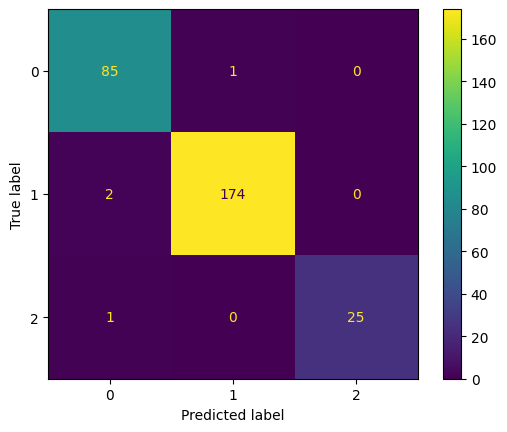

In [ ]:
# Построим матрицу ошибок
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [175]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.986


Гиперпараметры не изменили метрику accuracy модели!

**CatBoost**

In [194]:
model = CatBoostClassifier(
    iterations=100, depth=15, learning_rate=0.2,
   loss_function='MultiClass', verbose=False)

In [195]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
round(accuracy,3) 

0.983

Варьирование значениями learning rate и depth не повлияло на метрику accuracy!

**2.2. Лейкоциты (белые кровяные тельца, WBC)**

In [200]:
# Отбор наблюдений с данными по лейкоцитам
mask_l = (df['Кол. лаб. показатель'] == 'Лейкоциты') | (df['Кол. лаб. показатель'] == 'Лейкоциты (WBC)') | (df['Кол. лаб. показатель'] == 'WBC')
leu = df[mask_l]
leu

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
0,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.80,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
16,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.07,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
46,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.89,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
76,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),4.97,10*9/л,4:11,Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
104,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.64,10*9/л,4:11,Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36168,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),13.77,10*9/л,4:11,Повыш,Комментарий,"лимфоидные элементы средних размеров,с ядрами ...",_,М,"[1982, 02, 11 00:00:00]",42
36195,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),7.97,10*9/л,4:11,Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36217,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),9.65,10*9/л,4:11,Норм,Комментарий,Лимфоидные элементы с неправильной формой ядра...,_,М,"[1982, 02, 11 00:00:00]",42
36244,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),7.90,10*9/л,4:11,Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42


In [201]:
# Создадаим два столбца по верхней и нижней границам нормы содержания лейкоцитов
leu['Норма кол. показателя'] = leu['Норма кол. показателя'].apply(lambda x: x.split(':'))
leu['Нижняя граница'] = leu['Норма кол. показателя'].apply(lambda x: x[0])
leu['Нижняя граница'] = leu['Нижняя граница'].apply(lambda x: float(x.replace(',', '.')))
leu['Верхняя граница'] = leu['Норма кол. показателя'].apply(lambda x: x[1])
leu['Верхняя граница'] = leu['Верхняя граница'].apply(lambda x: float(x.replace(',', '.')))
leu

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\1416600831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leu['Норма кол. показателя'] = leu['Норма кол. показателя'].apply(lambda x: x.split(':'))
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\1416600831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leu['Нижняя граница'] = leu['Норма кол. показателя'].apply(lambda x: x[0])
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\1416600831.py:4: SettingWithCopyWarning: 
A value is trying to be set o

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст,Нижняя граница,Верхняя граница
0,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.80,10*9/л,"[4, 11]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,4.0,11.0
16,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.07,10*9/л,"[4, 11]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,4.0,11.0
46,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.89,10*9/л,"[4, 11]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,4.0,11.0
76,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),4.97,10*9/л,"[4, 11]",Норм,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,4.0,11.0
104,2e1d0b3f-488a-11ed-ab5a-0050568844e6,Плазмоклеточный лейкоз,Общий анализ крови,Лейкоциты (WBC),1.64,10*9/л,"[4, 11]",Пониж,NaN,NaN,NaN,Ж,"[1962, 09, 22 00:00:00]",62,4.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36168,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),13.77,10*9/л,"[4, 11]",Повыш,Комментарий,"лимфоидные элементы средних размеров,с ядрами ...",_,М,"[1982, 02, 11 00:00:00]",42,4.0,11.0
36195,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),7.97,10*9/л,"[4, 11]",Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42,4.0,11.0
36217,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),9.65,10*9/л,"[4, 11]",Норм,Комментарий,Лимфоидные элементы с неправильной формой ядра...,_,М,"[1982, 02, 11 00:00:00]",42,4.0,11.0
36244,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Лейкоциты (WBC),7.90,10*9/л,"[4, 11]",Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42,4.0,11.0


In [202]:
# Отберем столбцы с независимыми переменными модели
leu_ml = leu.loc[:,['Значение кол. показателя', 'Пол', 'Возраст']]
leu_ml

,Значение кол. показателя,Пол,Возраст
0,1.80,Ж,62
16,1.07,Ж,62
46,1.89,Ж,62
76,4.97,Ж,62
104,1.64,Ж,62
...,...,...,...
36168,13.77,М,42
36195,7.97,М,42
36217,9.65,М,42
36244,7.90,М,42


In [203]:
# Преобразуем столбец (пол) в числовой вид
X = pd.get_dummies(leu_ml, dtype=int)
X

,Значение кол. показателя,Возраст,Пол_Ж,Пол_М
0,1.80,62,1,0
16,1.07,62,1,0
46,1.89,62,1,0
76,4.97,62,1,0
104,1.64,62,1,0
...,...,...,...,...
36168,13.77,42,0,1
36195,7.97,42,0,1
36217,9.65,42,0,1
36244,7.90,42,0,1


In [204]:
# Преобразуем наименования таргета
y = leu['Флаг нормы кол. показателя']
y = y.map(lambda x: 'Норма' if x == 'Норм' else x)
y = y.map(lambda x: 'Лейкоцитоз' if x == 'Повыш' else x)
y = y.map(lambda x: 'Лейкопения' if x == 'Пониж' else x)
set(y)

{'Лейкопения', 'Лейкоцитоз', 'Норма'}

In [215]:
# Разделим набор данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=42)
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42, # генерация случайных чисел
    penalty = 'l2', C = 0.002  # добавление регуляризации L2
)

# Обучаем модель на тренировочной выборке 

log_reg.fit(X_train, y_train)

LogisticRegression(C=0.002, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [216]:
# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_test), 2)
# Делаем предсказание класса
y_pred = log_reg.predict(X_test)

# Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Норма', 'Пониж', 'Повыш']
)
# Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Норма,Пониж,Повыш,Predicted Class
7,0.47,0.01,0.52,Норма
163,0.17,0.07,0.76,Норма
126,0.43,0.01,0.56,Норма
127,0.00,0.97,0.03,Лейкоцитоз
209,0.01,0.25,0.74,Норма


In [217]:
# Определеим метрики качества полученной модели
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Лейкопения       1.00      0.90      0.95        69
  Лейкоцитоз       1.00      0.68      0.81        63
       Норма       0.85      1.00      0.92       155

    accuracy                           0.91       287
   macro avg       0.95      0.86      0.89       287
weighted avg       0.92      0.91      0.90       287



In [219]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.906


In [220]:
# Выполним сериализация полученной модели МО
with open('leuc.pickle', 'wb') as f:
    pickle.dump(log_reg, f)

**Случайный лес**

In [221]:
rf = RandomForestClassifier()  # Обучение модели
rf.fit(X_train, y_train)

RandomForestClassifier()

In [222]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.99


In [223]:
param_dist = {'n_estimators': randint(5,500),  # Подбор гиперпараметров для модели случайный лес
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023681019280>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000236810145B0>})

In [224]:
# Обновим классификатор, интегрируя наиболее оптимальные гиперпараметры
best_rf = rand_search.best_estimator_
print('Наиболее оптимальные гиперпараметры:',  rand_search.best_params_)

Наиболее оптимальные гиперпараметры: {'max_depth': 9, 'n_estimators': 215}


In [225]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.99


**CatBoost**

In [226]:
model = CatBoostClassifier(
    iterations=100, depth=15, learning_rate=0.2,
   loss_function='MultiClass', verbose=False)

In [227]:
model.fit(X_train, y_train)

In [228]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
round(accuracy,3) 

0.976

**2.3. Тромбоциты**


In [229]:
# Отбор строк с данными по тромбоцитам
mask_tr = (df['Кол. лаб. показатель'] == 'Тромбоциты') | (df['Кол. лаб. показатель'] == 'PLT')

tr = df[mask_tr]
tr

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
180,24612d4d-c466-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,Тромбоциты,347.0,10*9/л,150:450,Норм,NaN,NaN,NaN,Ж,"[1939, 02, 06 00:00:00]",85
757,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,224.0,10*9/л,150:450,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
879,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,232.0,10*9/л,150:450,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
895,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,212.0,10*9/л,150:450,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
956,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,204.0,10*9/л,150:450,Норм,Анизоцитоз,+,+-,М,"[1964, 05, 21 00:00:00]",60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28612,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,12.0,10*9/л,150:450,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28700,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,81.0,10*9/л,150:450,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28726,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,19.0,10*9/л,150:450,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28743,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,29.0,10*9/л,150:450,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65


In [230]:
# Создадаим два столбца по верхней и нижней границам нормы содержания тромбоцитов
tr['Норма кол. показателя'] = tr['Норма кол. показателя'].apply(lambda x: x.split(':'))
tr['Нижняя граница'] = tr['Норма кол. показателя'].apply(lambda x: x[0])
tr['Нижняя граница'] = tr['Нижняя граница'].apply(lambda x: float(x.replace(',', '.')))
tr['Верхняя граница'] = tr['Норма кол. показателя'].apply(lambda x: x[1])
tr['Верхняя граница'] = tr['Верхняя граница'].apply(lambda x: float(x.replace(',', '.')))
tr

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\2903056007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Норма кол. показателя'] = tr['Норма кол. показателя'].apply(lambda x: x.split(':'))
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\2903056007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Нижняя граница'] = tr['Норма кол. показателя'].apply(lambda x: x[0])
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\2903056007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст,Нижняя граница,Верхняя граница
180,24612d4d-c466-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,Тромбоциты,347.0,10*9/л,"[150, 450]",Норм,NaN,NaN,NaN,Ж,"[1939, 02, 06 00:00:00]",85,150.0,450.0
757,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,224.0,10*9/л,"[150, 450]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,150.0,450.0
879,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,232.0,10*9/л,"[150, 450]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,150.0,450.0
895,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,212.0,10*9/л,"[150, 450]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,150.0,450.0
956,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,PLT,204.0,10*9/л,"[150, 450]",Норм,Анизоцитоз,+,+-,М,"[1964, 05, 21 00:00:00]",60,150.0,450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28612,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,12.0,10*9/л,"[150, 450]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,150.0,450.0
28700,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,81.0,10*9/л,"[150, 450]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,150.0,450.0
28726,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,19.0,10*9/л,"[150, 450]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,150.0,450.0
28743,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,PLT,29.0,10*9/л,"[150, 450]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,150.0,450.0


In [232]:
# Отберем столбцы с независимыми переменными модели
tr_ml = tr.loc[:,['Значение кол. показателя', 'Пол', 'Возраст']]
tr_ml

# Преобразуем столбец (пол) в числовой вид
X = pd.get_dummies(tr_ml, dtype=int)
X

,Значение кол. показателя,Возраст,Пол_Ж,Пол_М
180,347.0,85,1,0
757,224.0,60,0,1
879,232.0,60,0,1
895,212.0,60,0,1
956,204.0,60,0,1
...,...,...,...,...
28612,12.0,65,1,0
28700,81.0,65,1,0
28726,19.0,65,1,0
28743,29.0,65,1,0


In [233]:
# Преобразуем наименования таргета
y = tr['Флаг нормы кол. показателя']
y = y.map(lambda x: 'Норма' if x == 'Норм' else x)
y = y.map(lambda x: 'Тромбоцитоз' if x == 'Повыш' else x)
y = y.map(lambda x: 'Тромбопения' if x == 'Пониж' else x)
set(y)

{'Норма', 'Тромбопения', 'Тромбоцитоз'}

In [248]:
# Разделим набор данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=42)
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42, # генерация случайных чисел
    penalty='l2', C = 0.00001  # добавление регуляризации
)

# Обучаем модель на тренировочной выборке 

log_reg.fit(X_train, y_train)

LogisticRegression(C=1e-05, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [249]:
# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_test), 2)
# Делаем предсказание класса
y_pred = log_reg.predict(X_test)

# Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Норма', 'Пониж', 'Повыш']
)
# Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Норма,Пониж,Повыш,Predicted Class
78,0.82,0.11,0.07,Норма
30,0.49,0.50,0.01,Тромбопения
57,0.53,0.00,0.47,Норма
24,0.04,0.96,0.00,Тромбопения
16,0.73,0.01,0.25,Норма


In [250]:
# Определеим метрики качества полученной модели
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Норма       0.97      0.81      0.88        37
 Тромбопения       0.88      1.00      0.94        45
 Тромбоцитоз       0.95      0.95      0.95        19

    accuracy                           0.92       101
   macro avg       0.93      0.92      0.92       101
weighted avg       0.93      0.92      0.92       101



In [251]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.921


In [252]:
# Выполним сериализация полученной модели МО
with open('tromboc.pickle', 'wb') as f:
    pickle.dump(log_reg, f)

**Случайный лес**

In [255]:
rf = RandomForestClassifier()  # Обучение модели
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.96


In [256]:
param_dist = {'n_estimators': randint(5,500),  # Подбор гиперпараметров для модели случайный лес
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002368109B370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002368104E250>})

In [257]:
# Обновим классификатор, интегрируя наиболее оптимальные гиперпараметры
best_rf = rand_search.best_estimator_
print('Наиболее оптимальные гиперпараметры:',  rand_search.best_params_)

Наиболее оптимальные гиперпараметры: {'max_depth': 3, 'n_estimators': 433}


In [258]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.97


**CatBoost**

In [253]:
model = CatBoostClassifier(
    iterations=100, depth=15, learning_rate=0.2,
   loss_function='MultiClass', verbose=False)

In [254]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
round(accuracy,3) 

0.98

**2.4. Гемоглобин (Hb)**

In [282]:
# Отбор строк с данными по гемоглобину
mask_hb = (df['Кол. лаб. показатель'] == 'Гемоглобин') | (df['Кол. лаб. показатель'] == 'HGB')

hb = df[mask_hb]
hb

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
175,24612d4d-c466-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,Гемоглобин,72.0,г/л,117:160,Пониж,NaN,NaN,NaN,Ж,"[1939, 02, 06 00:00:00]",85
752,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,162.0,г/л,132:180,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
874,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,168.0,г/л,132:180,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
890,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,172.0,г/л,132:180,Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60
934,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,181.0,г/л,132:180,Повыш,Анизоцитоз,+,+-,М,"[1964, 05, 21 00:00:00]",60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28607,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,98.0,г/л,117:180,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28695,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,124.0,г/л,117:180,Норм,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28721,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,114.0,г/л,117:180,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65
28738,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,101.0,г/л,117:180,Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65


In [283]:
# Создадаим два столбца по верхней и нижней границам нормы содержания гемоглобина
hb['Норма кол. показателя'] = hb['Норма кол. показателя'].apply(lambda x: x.split(':'))
hb['Нижняя граница'] = hb['Норма кол. показателя'].apply(lambda x: x[0])
hb['Нижняя граница'] = hb['Нижняя граница'].apply(lambda x: float(x.replace(',', '.')))
hb['Верхняя граница'] = hb['Норма кол. показателя'].apply(lambda x: x[1])
hb['Верхняя граница'] = hb['Верхняя граница'].apply(lambda x: float(x.replace(',', '.')))
hb

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\4122771081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hb['Норма кол. показателя'] = hb['Норма кол. показателя'].apply(lambda x: x.split(':'))
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\4122771081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hb['Нижняя граница'] = hb['Норма кол. показателя'].apply(lambda x: x[0])
C:\Users\Эдгар\AppData\Local\Temp\ipykernel_27792\4122771081.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст,Нижняя граница,Верхняя граница
175,24612d4d-c466-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,Гемоглобин,72.0,г/л,"[117, 160]",Пониж,NaN,NaN,NaN,Ж,"[1939, 02, 06 00:00:00]",85,117.0,160.0
752,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,162.0,г/л,"[132, 180]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,132.0,180.0
874,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,168.0,г/л,"[132, 180]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,132.0,180.0
890,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,172.0,г/л,"[132, 180]",Норм,NaN,NaN,NaN,М,"[1964, 05, 21 00:00:00]",60,132.0,180.0
934,76416b20-b70b-11ec-ab54-0050568844e6,Другой уточненный лейкоз,Общий анализ крови,HGB,181.0,г/л,"[132, 180]",Повыш,Анизоцитоз,+,+-,М,"[1964, 05, 21 00:00:00]",60,132.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28607,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,98.0,г/л,"[117, 180]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,117.0,180.0
28695,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,124.0,г/л,"[117, 180]",Норм,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,117.0,180.0
28721,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,114.0,г/л,"[117, 180]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,117.0,180.0
28738,b2fd5cf8-6829-11ea-80cc-901b0e63368b,Острый миелоидный лейкоз,Общий анализ крови,HGB,101.0,г/л,"[117, 180]",Пониж,NaN,NaN,NaN,Ж,"[1959, 07, 31 00:00:00]",65,117.0,180.0


In [303]:
# Отберем столбцы с независимыми переменными модели
hb_ml = hb.loc[:,['Значение кол. показателя', 'Пол', 'Возраст']]
hb_ml

# Преобразуем столбец (пол) в числовой вид
X = pd.get_dummies(hb_ml, dtype=int)
X

,Значение кол. показателя,Возраст,Пол_Ж,Пол_М
175,72.0,85,1,0
752,162.0,60,0,1
874,168.0,60,0,1
890,172.0,60,0,1
934,181.0,60,0,1
...,...,...,...,...
28607,98.0,65,1,0
28695,124.0,65,1,0
28721,114.0,65,1,0
28738,101.0,65,1,0


In [304]:
# Преобразуем наименования таргета
y = hb['Флаг нормы кол. показателя']
y = y.map(lambda x: 'Норма' if x == 'Норм' else x)
y = y.map(lambda x: 'Эритроцитоз' if x == 'Повыш' else x)
y = y.map(lambda x: 'Анемия (неподтвержденная)' if x == 'Пониж' else x)
set(y)

{'Анемия (неподтвержденная)', 'Норма', 'Эритроцитоз'}

In [305]:
# Разделим набор данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=42)
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42, # генерация случайных чисел
    penalty='l2', C = 0.0001
)

# Обучаем модель на тренировочной выборке 

log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [306]:
# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_test), 2)
# Делаем предсказание класса
y_pred = log_reg.predict(X_test)

# Создаём DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Норма', 'Пониж', 'Повыш']
)
# Создаём DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
#Выбираем пять случайных строк
y_df.sample(5, random_state=2)

,Норма,Пониж,Повыш,Predicted Class
78,0.08,0.75,0.17,Норма
30,0.03,0.72,0.25,Норма
57,0.78,0.20,0.02,Анемия (неподтвержденная)
24,0.99,0.01,0.00,Анемия (неподтвержденная)
16,0.92,0.07,0.00,Анемия (неподтвержденная)


In [307]:
# Определеим метрики качества полученной модели
print(metrics.classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

Анемия (неподтвержденная)       0.92      1.00      0.96        69
                    Норма       0.88      0.79      0.84        29
              Эритроцитоз       0.00      0.00      0.00         3

                 accuracy                           0.91       101
                macro avg       0.60      0.60      0.60       101
             weighted avg       0.88      0.91      0.89       101



c:\Users\Эдгар\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Эдгар\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Эдгар\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [308]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.911


In [309]:
# Выполним сериализация полученной модели МО
with open('HB.pickle', 'wb') as f:
    pickle.dump(log_reg, f)

**Случайный лес**

In [291]:
rf = RandomForestClassifier()  # Обучение модели
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.96


In [294]:
param_dist = {'n_estimators': randint(5,500),  # Подбор гиперпараметров для модели случайный лес
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002368E1A1160>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002368115F1F0>})

In [295]:
# Обновим классификатор, интегрируя наиболее оптимальные гиперпараметры
best_rf = rand_search.best_estimator_
print('Наиболее оптимальные гиперпараметры:',  rand_search.best_params_)

Наиболее оптимальные гиперпараметры: {'max_depth': 13, 'n_estimators': 479}


In [296]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.96


**CatBoost**

In [297]:
model = CatBoostClassifier(
    iterations=100, depth=15, learning_rate=0.2,
   loss_function='MultiClass', verbose=False)

In [298]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
round(accuracy,3) 

0.97

**Полученные модели показывают достаточно высокие скоры предсказательной способности (F1-мера в большинстве случаев  > 0.90). Однако в процессе дальнейшей работы следует расширить объем данных. Вероятно, модели на текущей выборке могли переобучиться/недобучиться в предсказании того или иного класса. Далее эти модели будут интегрированы в сервис, по результатам работы которого пациент сможет получить некоторые медицинские рекомендации.**

**Данные в столбцах "верхняя граница" и "нижняя граница" будут использованы для дополнительной разметки датасета и предсказания более точного диагноза и более обстоятельной рекомендации для пациента.**

**Выборка данных по одному пациента для тестирования сервиса**

In [300]:
# Отберем показатели биохимического анализа крови одного из пациента для тестирования работу сервиса
test_pat = df[df['ID истории болезни']=='516f652e-8bb8-11eb-bb95-2cea7fe73f75']
test_pat.to_csv('data.csv', index=False)

In [336]:
t2 = df[df['ID истории болезни']=='6166e156-c1af-11ed-8602-005056880ecb']
t2 = t2.iloc[1:23]
t2.to_csv('data2.csv', index=False)

In [337]:
t2

,ID истории болезни,Осн. диаг. при выписке МКБ10 (текст),Заголовок документа,Кол. лаб. показатель,Значение кол. показателя,Ед. изм. кол. показателя,Норма кол. показателя,Флаг нормы кол. показателя,Кач. лаб. показатель,Значение кач. показателя,Норма кач. показателя,Пол,Дата рождения пациента,Возраст
36147,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Эритроциты (RBC),1.18,10*12/л,"4,3:6,1",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36148,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Гемоглобин (HGB),46.00,г/л,132:180,Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36149,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Гематокрит (HCT),15.00,%,39:52,Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36150,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Средний объем эритроцита (MCV),124.00,фл,80:99,Повыш,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36151,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Среднее содержание гемоглобина в эритроците (MCH),39.00,пг,27:38,Повыш,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36152,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Средняя концентрация гемоглобина в эритроците ...,315.00,г/л,300:380,Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36153,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Тромбоциты (PLT),41.00,10*9/л,150:450,Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36154,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,Тромбокрит (PCT),0.05,%,"0,19:0,36",Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36155,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,"Нейтрофилы, относительное количество (NE%)",1.80,%,45:72,Пониж,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
36156,6166e156-c1af-11ed-8602-005056880ecb,Острый лейкоз неуточненного клеточного типа,Общий анализ крови,"Лимфоциты, относительное количество (LY%)",40.20,%,18:44,Норм,NaN,NaN,NaN,М,"[1982, 02, 11 00:00:00]",42
